In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import json
import os
import imantics
from PIL import Image
from skimage.transform import resize
import random
from sklearn.model_selection import train_test_split

%matplotlib inline

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

2024-11-03 17:25:29.272163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-03 17:25:29.282333: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-03 17:25:29.285437: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-03 17:25:29.293782: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-03 17:25:29.813060: W tensorflow/compiler/tf2

In [4]:
CURRENT_DIR = os.getcwd()
annote_dir = f'{CURRENT_DIR}/annotations/instances_default.json'
images_dir = f'{CURRENT_DIR}/images' 

In [5]:
image_size = 512
input_image_size = (1920, 1080)

images_listdir = os.listdir(images_dir)
print(f"Dataset contains {red}{len(images_listdir)} {res}images")

Dataset contains 512 images


In [6]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_size, image_size))
    return img

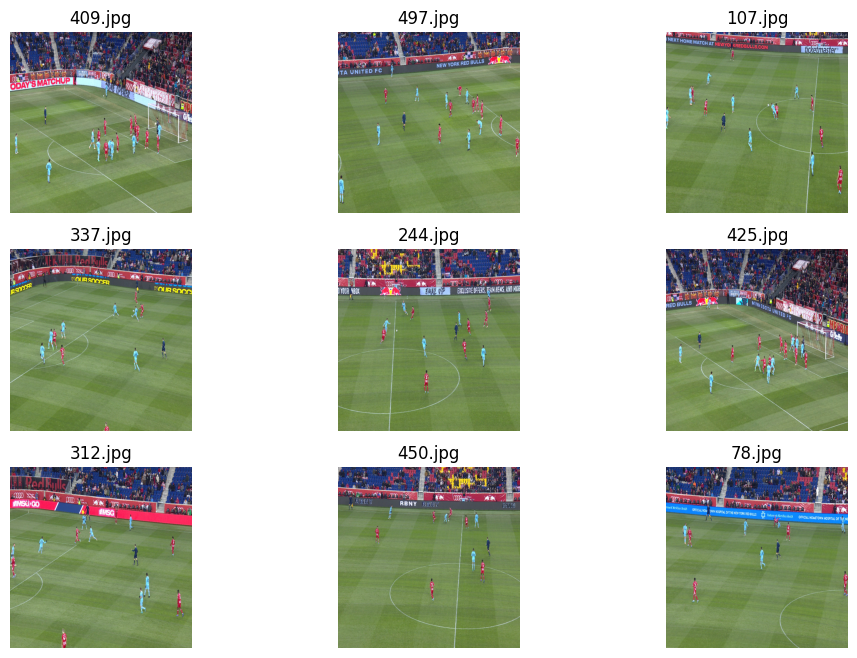

In [7]:
random_images = np.random.choice(images_listdir, size = 9, replace = False) 

rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (12,8))

for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_image(f"{images_dir}/{random_images[i]}")
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

In [8]:
annote = json.load(open(annote_dir)) 
id_to_images = {image['id']:image['file_name'] for image in annote['images']} 

images = np.zeros((len(images_listdir), image_size, image_size, 3), dtype=np.uint8)

for image_id, image_filename in id_to_images.items():
    cur_image = read_image(f"{images_dir}/{image_filename}")
    images[image_id - 1] = cur_image

masks = np.zeros((len(images_listdir), image_size, image_size, 1), dtype=bool)

for annotation in annote["annotations"]:
    image_id = annotation["image_id"]
    segmentation = annotation["segmentation"]

    cur_mask = imantics.Polygons(segmentation).mask(*input_image_size).array
    cur_mask = np.expand_dims(resize(cur_mask, (image_size, image_size), mode='constant', preserve_range=True), 2)

    mask_index = image_id - 1
    masks[mask_index] = masks[mask_index] | cur_mask

print(f"We have {red}{len(images)} {res}images and {red}{len(masks)} {res}masks ")

We have 512 images and 512 masks 


In [9]:
images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.05, random_state=42)

print(f"== Training set shapes == \nImages : {red}{images_train.shape}\n{res}Masks : {red}{masks_train.shape}")
print(f"{res}== Test set shapes == \nImages : {red}{images_test.shape}\n{res}Masks : {red}{masks_test.shape}")

== Training set shapes == 
Images : (486, 512, 512, 3)
Masks : (486, 512, 512, 1)
== Test set shapes == 
Images : (26, 512, 512, 3)
Masks : (26, 512, 512, 1)


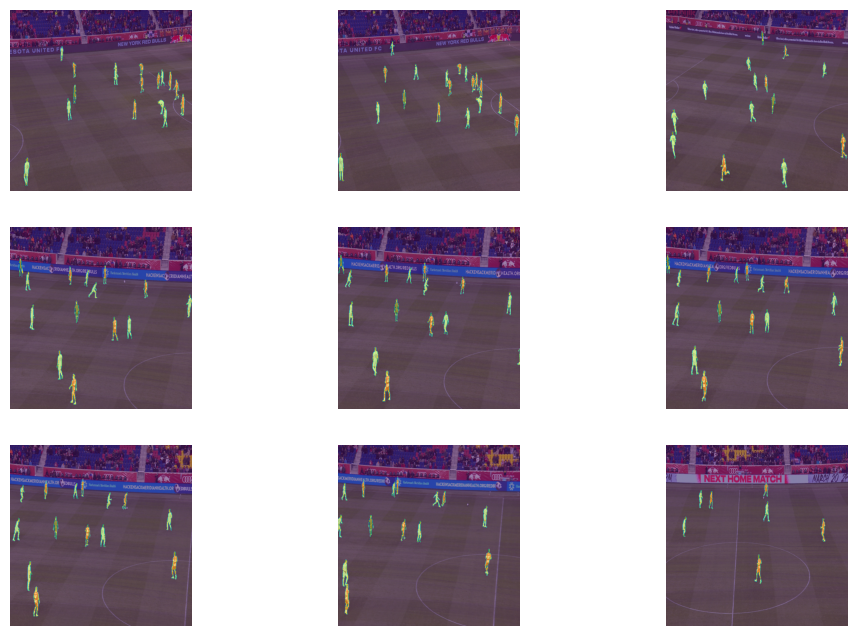

In [10]:
random_numbers = [random.randint(0, 511) for _ in range(9)] 

fig, ax = plt.subplots(rows, cols, figsize = (12,8))
for i, ax in enumerate(ax.flat):
    if i < len(random_numbers):
        ax.imshow(images[i])
        ax.imshow(masks[i], alpha=0.5)
        ax.axis('off')

# U-NET TRAINING

In [25]:
def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

In [26]:
def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2, 2))(skip)
    return skip, pool

In [27]:
def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

In [28]:
def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)

    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)

    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

In [29]:
unet_model = Unet((512, 512, 3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#unet_model.summary()

In [35]:
unet_result = unet_model.fit(images_train, masks_train, validation_split = 0.2, batch_size = 4, epochs = 5)

Epoch 1/5


2024-11-03 17:52:59.488143: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 32.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-03 17:53:00.105038: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-03 17:53:01.098674: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 33.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-03 17:53:02.135224: W external/local_tsl/tsl/framework/b

97/97 ━━━━━━━━━━━━━━━━━━━━ 94s 593ms/step - accuracy: 0.9417 - loss: 0.2388 - val_accuracy: 0.0617 - val_loss: 5.6411
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 57s 585ms/step - accuracy: 0.9959 - loss: 0.0351 - val_accuracy: 0.9941 - val_loss: 0.0385
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 57s 589ms/step - accuracy: 0.9971 - loss: 0.0184 - val_accuracy: 0.9966 - val_loss: 0.0176
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 57s 592ms/step - accuracy: 0.9976 - loss: 0.0120 - val_accuracy: 0.9973 - val_loss: 0.0119
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 58s 594ms/step - accuracy: 0.9977 - loss: 0.0097 - val_accuracy: 0.9973 - val_loss: 0.0097


# U²-NET TRAINING

In [15]:
def conv_block(shape, out_ch, rate=1):
    x = tf.keras.layers.Conv2D(out_ch, 3, padding="same", dilation_rate=1)(shape)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x

In [16]:
def RSU_L(shape, out_ch, M_ch, num_layers, rate=2):
    x = conv_block(shape, out_ch)
    inp_ch = x

    skip_features = []
    x = conv_block(x, M_ch)
    skip_features.append(x)

    for i in range(num_layers-2):
        x = tf.keras.layers.MaxPool2D((2, 2))(x)
        x = conv_block(x, M_ch)
        skip_features.append(x)
        
    x = conv_block(x, M_ch, rate=rate)
    skip_features.reverse()
    x = tf.keras.layers.Concatenate()([x, skip_features[0]])
    x = conv_block(x, M_ch)

    for i in range(num_layers-3):
        x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
        x = tf.keras.layers.Concatenate()([x, skip_features[i+1]])
        x = conv_block(x, M_ch)

    x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = tf.keras.layers.Concatenate()([x, skip_features[-1]])
    x = conv_block(x, out_ch)

    x = tf.keras.layers.Add()([x, inp_ch])
    return x

In [17]:
def RSU_4F(shape, out_ch, M_ch):
    x0 = conv_block(shape, out_ch, rate=1)

    x1 = conv_block(x0, M_ch, rate=1)
    x2 = conv_block(x1, M_ch, rate=2)
    x3 = conv_block(x2, M_ch, rate=4)

    x4 = conv_block(x3, M_ch, rate=8)

    x = tf.keras.layers.Concatenate()([x4, x3])
    x = conv_block(x, M_ch, rate=4)

    x = tf.keras.layers.Concatenate()([x, x2])
    x = conv_block(x, M_ch, rate=2)

    x = tf.keras.layers.Concatenate()([x, x1])
    x = conv_block(x, out_ch, rate=1)

    x = tf.keras.layers.Add()([x, x0])
    return x

In [18]:
def u2net(shape, out_ch, M_ch, num_classes=1):
    inputs = tf.keras.layers.Input(shape)

    e1 = RSU_L(inputs, out_ch[0], M_ch[0], 7)
    p1 = tf.keras.layers.MaxPool2D((2, 2))(e1)

    e2 = RSU_L(p1, out_ch[1], M_ch[1], 6)
    p2 = tf.keras.layers.MaxPool2D((2, 2))(e2)

    e3 = RSU_L(p2, out_ch[2], M_ch[2], 5)
    p3 = tf.keras.layers.MaxPool2D((2, 2))(e3)

    e4 = RSU_L(p3, out_ch[3], M_ch[3], 4)
    p4 = tf.keras.layers.MaxPool2D((2, 2))(e4)

    e5 = RSU_4F(p4, out_ch[4], M_ch[4])
    p5 = tf.keras.layers.MaxPool2D((2, 2))(e5)

    b1 = RSU_4F(p5, out_ch[5], M_ch[5])
    b2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(b1)

    d1 = tf.keras.layers.Concatenate()([b2, e5])
    d1 = RSU_4F(d1, out_ch[6], M_ch[6])
    u1 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d1)

    d2 = tf.keras.layers.Concatenate()([u1, e4])
    d2 = RSU_L(d2, out_ch[7], M_ch[7], 4)
    u2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d2)

    d3 = tf.keras.layers.Concatenate()([u2, e3])
    d3 = RSU_L(d3, out_ch[8], M_ch[8], 5)
    u3 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d3)

    d4 = tf.keras.layers.Concatenate()([u3, e2])
    d4 = RSU_L(d4, out_ch[9], M_ch[9], 6)
    u4 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d4)

    d5 = tf.keras.layers.Concatenate()([u4, e1])
    d5 = RSU_L(d5, out_ch[10], M_ch[10], 7)

    
    y1 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d5)

    y2 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d4)
    y2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(y2)

    y3 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d3)
    y3 = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(y3)

    y4 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d2)
    y4 = tf.keras.layers.UpSampling2D(size=(8, 8), interpolation="bilinear")(y4)

    y5 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d1)
    y5 = tf.keras.layers.UpSampling2D(size=(16, 16), interpolation="bilinear")(y5)

    y6 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(b1)
    y6 = tf.keras.layers.UpSampling2D(size=(32, 32), interpolation="bilinear")(y6)

    y0 = tf.keras.layers.Concatenate()([y1, y2, y3, y4, y5, y6])
    y0 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(y0)

    y0 = tf.keras.layers.Activation("sigmoid")(y0)
    y1 = tf.keras.layers.Activation("sigmoid")(y1)
    y2 = tf.keras.layers.Activation("sigmoid")(y2)
    y3 = tf.keras.layers.Activation("sigmoid")(y3)
    y4 = tf.keras.layers.Activation("sigmoid")(y4)
    y5 = tf.keras.layers.Activation("sigmoid")(y5)
    y6 = tf.keras.layers.Activation("sigmoid")(y6)

    model = tf.keras.models.Model(inputs, outputs=y0, name="U2-Net")
    return model

In [19]:
def build_u2net(input_shape, num_classes=1):
    out_ch = [64, 128, 256, 512, 512, 512, 512, 256, 128, 64, 64]
    M_ch = [32, 32, 64, 128, 256, 256, 256, 128, 64, 32, 16]
    model = u2net(input_shape, out_ch, M_ch, num_classes=num_classes)
    return model


In [20]:
def build_u2net_lite(input_shape, num_classes=1):
    out_ch = [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
    M_ch = [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
    model = u2net(input_shape, out_ch, M_ch, num_classes=num_classes)
    return model

In [21]:
u2net_model = build_u2net((image_size, image_size, 3))
u2net_model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
#u2net_model.summary()

I0000 00:00:1730654798.499200    5343 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730654798.530855    5343 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730654798.531038    5343 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730654798.531738    5343 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [23]:
u2netlite_model = build_u2net_lite((image_size, image_size, 3))
u2netlite_model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
#u2netlite_model.summary()

# U2net training 

In [22]:
u2net_result = u2net_model.fit(images_train, masks_train, validation_split = 0.2, batch_size = 4, epochs = 5)

Epoch 1/5


I0000 00:00:1730654830.590893    5485 service.cc:146] XLA service 0x7feaa8001380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730654830.590915    5485 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-11-03 17:27:11.655593: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-03 17:27:15.251114: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-11-03 17:27:41.056587: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[4,128,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,64,512,512]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_qu

97/97 ━━━━━━━━━━━━━━━━━━━━ 216s 874ms/step - accuracy: 0.9786 - loss: 0.0679 - val_accuracy: 0.9791 - val_loss: 920.5820
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 71s 729ms/step - accuracy: 0.9969 - loss: 0.0081 - val_accuracy: 0.9959 - val_loss: 0.0250
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 70s 724ms/step - accuracy: 0.9975 - loss: 0.0065 - val_accuracy: 0.9973 - val_loss: 0.0069
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 69s 715ms/step - accuracy: 0.9977 - loss: 0.0058 - val_accuracy: 0.9974 - val_loss: 0.0067
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 69s 713ms/step - accuracy: 0.9977 - loss: 0.0059 - val_accuracy: 0.9978 - val_loss: 0.0055


# U2net-lite training

In [24]:
u2netlite_result = u2netlite_model.fit(images_train, masks_train, validation_split = 0.2, batch_size = 4, epochs = 5)

Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 105s 459ms/step - accuracy: 0.9473 - loss: 0.1141 - val_accuracy: 0.9851 - val_loss: 0.0760
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 393ms/step - accuracy: 0.9965 - loss: 0.0093 - val_accuracy: 0.9945 - val_loss: 0.0149
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 395ms/step - accuracy: 0.9974 - loss: 0.0067 - val_accuracy: 0.9971 - val_loss: 0.0074
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 396ms/step - accuracy: 0.9977 - loss: 0.0059 - val_accuracy: 0.9976 - val_loss: 0.0059
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 395ms/step - accuracy: 0.9978 - loss: 0.0054 - val_accuracy: 0.9975 - val_loss: 0.0062


# Test Models

## UNET testing

In [ ]:
unet_predict = unet_model.predict(images_test, batch_size = 4)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step


In [46]:
unet_predict = (unet_predict >= 0.5).astype(np.uint8)

## U2NET testing

In [ ]:
u2net_predict = u2net_model.predict(images_test, batch_size = 4)

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 773ms/step


In [45]:
u2net_predict = (u2net_predict >= 0.5).astype(np.uint8)

## U2NET-LITE TESTING

In [ ]:
u2netlite_predict = u2netlite_model.predict(images_test, batch_size = 4)

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 631ms/step


In [44]:
u2netlite_predict = (u2netlite_predict >= 0.5).astype(np.uint8)

# Displaying Results

In [49]:
def show_result(og, unet, u2net, u2netlite, target):
    _, axs = plt.subplots(1, 5, figsize=(20, 10))
    axs[0].set_title("Original")
    axs[0].imshow(og)
    axs[0].axis('off')
    
    axs[1].set_title("U-Net")
    axs[1].imshow(unet)
    axs[1].axis('off')
    
    axs[2].set_title("U2-Net")
    axs[2].imshow(u2net)
    axs[2].axis('off')
    
    axs[3].set_title("U2-Net-Lite")
    axs[3].imshow(u2netlite)
    axs[3].axis('off')

    axs[4].set_title("True Label (Human)")
    axs[4].imshow(target)
    axs[4].axis('off')

    plt.show()

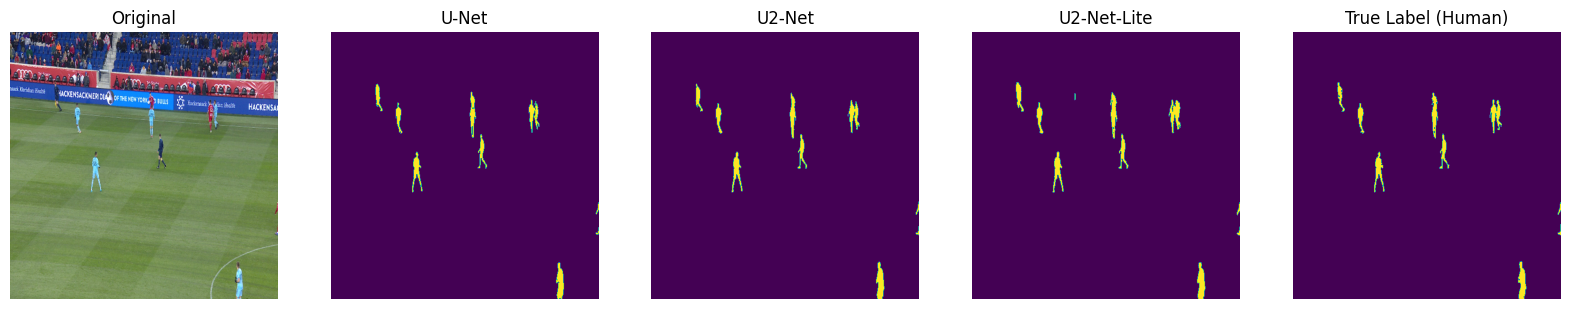

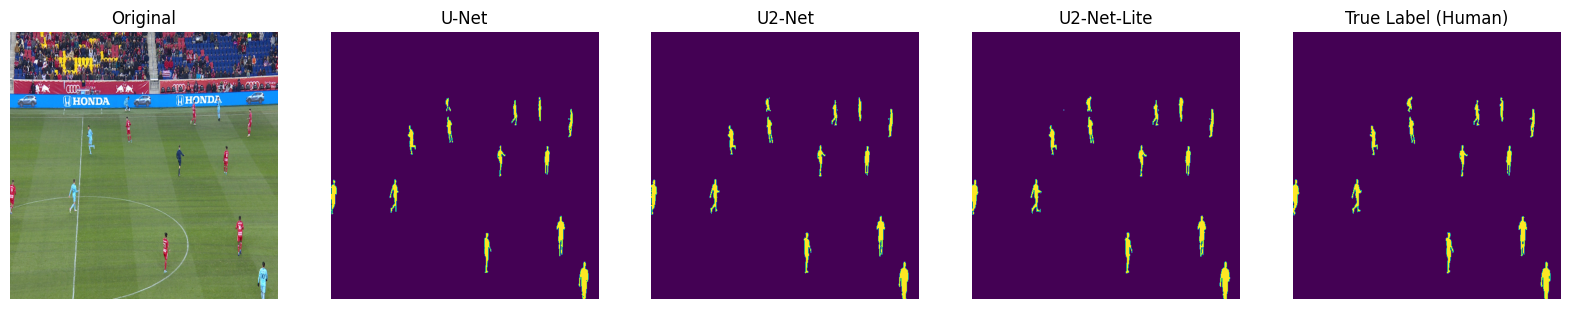

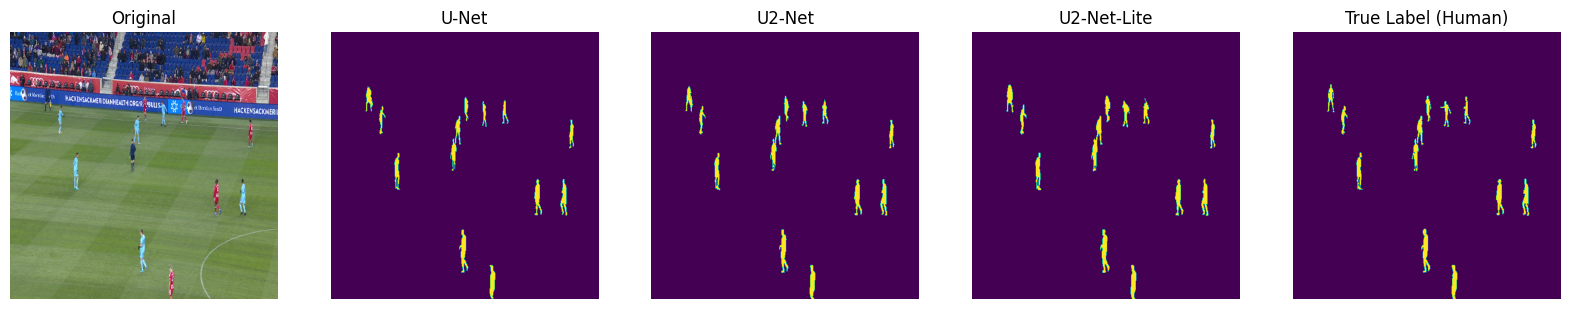

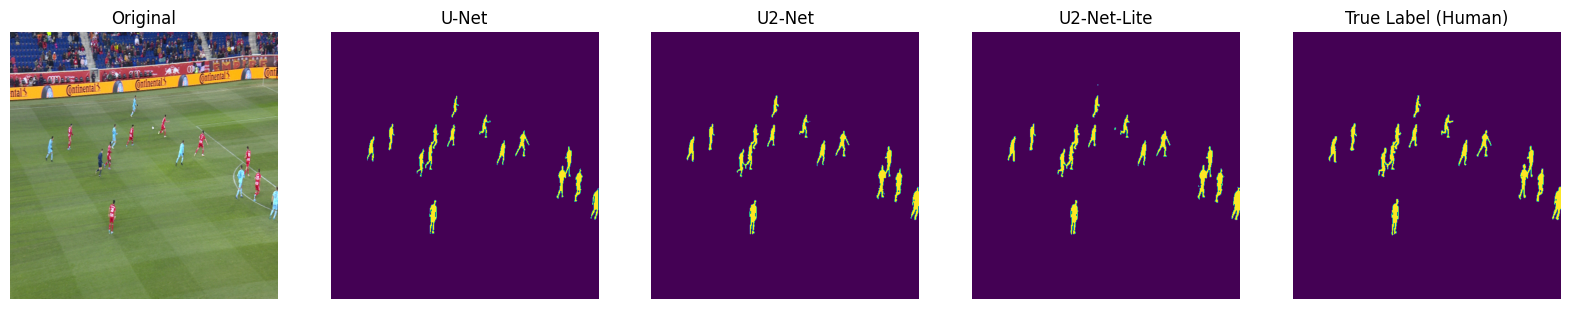

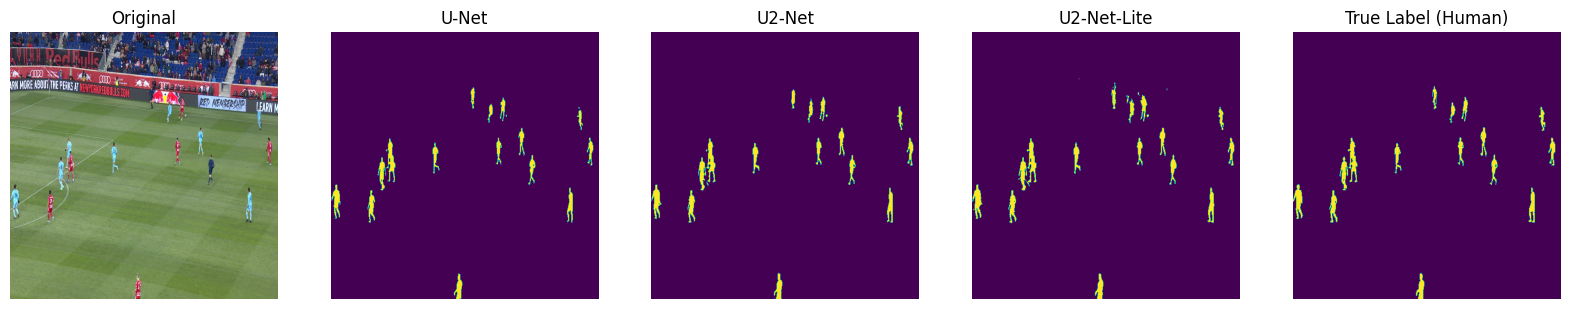

In [50]:
show_test_idx = random.sample(range(26), 5)
for idx in show_test_idx: 
    show_result(images_test[idx], unet_predict[idx], u2net_predict[idx], u2netlite_predict[idx], masks_test[idx])